## Self Supervised Learning by Convolutional Auto-Encoder with Random Images

Train Convolutional Auto-Encoder with Random Images

In [10]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch import rand, randn

data_dir = 'data'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [11]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
        #     nn.Linear(3 * 3 * 32, 128),
        #     nn.ReLU(True),
        #     nn.Linear(128, encoded_space_dim)
            nn.Linear(7 * 7 * 16, encoded_space_dim) 
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
#        print(x.shape)
        x = self.flatten(x)
#        print(x.shape)
        x = self.encoder_lin(x)
#        print(x.shape)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            # nn.Linear(encoded_space_dim, 128),
            # nn.ReLU(True),
            # nn.Linear(128, 3 * 3 * 32),
            nn.Linear(encoded_space_dim, 7 * 7 * 16),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 7, 7))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 1, 3, stride=1, padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
#        print(x.shape)
        x = self.unflatten(x)
#        print(x.shape)
        x = self.decoder_conv(x)
#        print(x.shape)
        x = torch.sigmoid(x)
        return x

In [12]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 100

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 7, 7))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [13]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        image_batch = rand((255, 1, 28, 28))
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
#        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [14]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = rand((255, 1, 28, 28))
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [15]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      # img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      img = rand((1, 1, 28, 28)).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

EPOCH 1/200 	 train loss 0.08118483424186707 	 val loss 0.07690563797950745
EPOCH 2/200 	 train loss 0.07498300075531006 	 val loss 0.07386938482522964
EPOCH 3/200 	 train loss 0.07345030456781387 	 val loss 0.0732341855764389
EPOCH 4/200 	 train loss 0.07323651760816574 	 val loss 0.07317931205034256
EPOCH 5/200 	 train loss 0.07316067069768906 	 val loss 0.07316248118877411
EPOCH 6/200 	 train loss 0.07312978059053421 	 val loss 0.07309006154537201
EPOCH 7/200 	 train loss 0.07312452048063278 	 val loss 0.07312562316656113
EPOCH 8/200 	 train loss 0.07306797057390213 	 val loss 0.0731014683842659
EPOCH 9/200 	 train loss 0.07309412211179733 	 val loss 0.07313806563615799
EPOCH 10/200 	 train loss 0.07308971881866455 	 val loss 0.07309523224830627


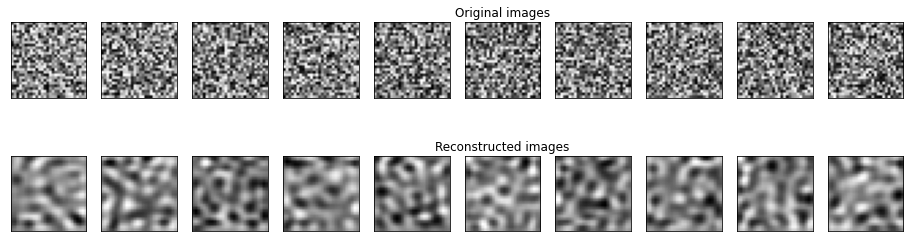

EPOCH 11/200 	 train loss 0.07306620478630066 	 val loss 0.07303821295499802
EPOCH 12/200 	 train loss 0.07306940853595734 	 val loss 0.0731290802359581
EPOCH 13/200 	 train loss 0.07305600494146347 	 val loss 0.07318617403507233
EPOCH 14/200 	 train loss 0.0730385109782219 	 val loss 0.07305478304624557
EPOCH 15/200 	 train loss 0.07305244356393814 	 val loss 0.07302288711071014
EPOCH 16/200 	 train loss 0.07303235679864883 	 val loss 0.07306374609470367
EPOCH 17/200 	 train loss 0.07307559251785278 	 val loss 0.07309602946043015
EPOCH 18/200 	 train loss 0.07303652912378311 	 val loss 0.07320252805948257
EPOCH 19/200 	 train loss 0.07301884144544601 	 val loss 0.07308714836835861
EPOCH 20/200 	 train loss 0.07301986962556839 	 val loss 0.07306578010320663


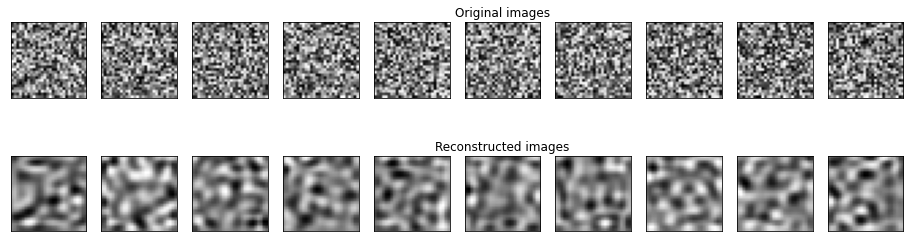

EPOCH 21/200 	 train loss 0.07302574068307877 	 val loss 0.07304030656814575
EPOCH 22/200 	 train loss 0.07302401959896088 	 val loss 0.07305530458688736
EPOCH 23/200 	 train loss 0.07300589978694916 	 val loss 0.07313963025808334
EPOCH 24/200 	 train loss 0.07301990687847137 	 val loss 0.07304093986749649
EPOCH 25/200 	 train loss 0.07301919162273407 	 val loss 0.07305685430765152
EPOCH 26/200 	 train loss 0.0730179101228714 	 val loss 0.07342086732387543
EPOCH 27/200 	 train loss 0.07303325831890106 	 val loss 0.07305461168289185
EPOCH 28/200 	 train loss 0.07303021848201752 	 val loss 0.07316351681947708
EPOCH 29/200 	 train loss 0.0730128064751625 	 val loss 0.07302047312259674
EPOCH 30/200 	 train loss 0.0730319395661354 	 val loss 0.07309500873088837


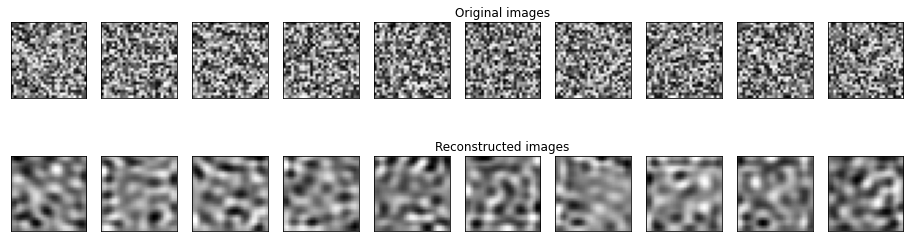

EPOCH 31/200 	 train loss 0.07302471250295639 	 val loss 0.07317006587982178
EPOCH 32/200 	 train loss 0.07300969213247299 	 val loss 0.07299017906188965
EPOCH 33/200 	 train loss 0.07301194220781326 	 val loss 0.0732111781835556
EPOCH 34/200 	 train loss 0.07300733774900436 	 val loss 0.07310996949672699
EPOCH 35/200 	 train loss 0.07301836460828781 	 val loss 0.07305511087179184
EPOCH 36/200 	 train loss 0.07300785928964615 	 val loss 0.07310406863689423
EPOCH 37/200 	 train loss 0.07299263775348663 	 val loss 0.07303706556558609
EPOCH 38/200 	 train loss 0.07301432639360428 	 val loss 0.0730762928724289
EPOCH 39/200 	 train loss 0.07299944758415222 	 val loss 0.0730721578001976
EPOCH 40/200 	 train loss 0.07299383729696274 	 val loss 0.07324833422899246


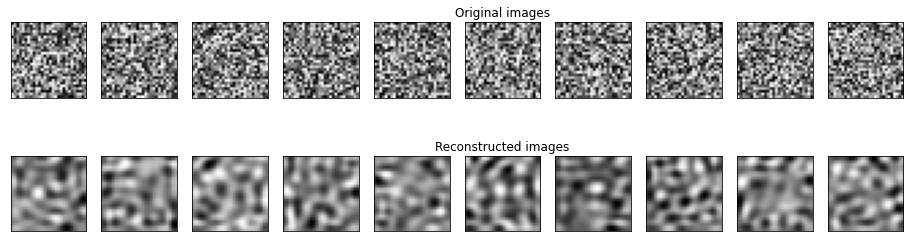

EPOCH 41/200 	 train loss 0.07302513718605042 	 val loss 0.07312367111444473
EPOCH 42/200 	 train loss 0.07302963733673096 	 val loss 0.07312433421611786
EPOCH 43/200 	 train loss 0.07302869856357574 	 val loss 0.07300935685634613
EPOCH 44/200 	 train loss 0.07300344854593277 	 val loss 0.07321411371231079
EPOCH 45/200 	 train loss 0.07298987358808517 	 val loss 0.07305629551410675
EPOCH 46/200 	 train loss 0.07298927009105682 	 val loss 0.07343176007270813
EPOCH 47/200 	 train loss 0.07302439212799072 	 val loss 0.0730590894818306
EPOCH 48/200 	 train loss 0.07298357784748077 	 val loss 0.07305298745632172
EPOCH 49/200 	 train loss 0.07300367951393127 	 val loss 0.07302901148796082
EPOCH 50/200 	 train loss 0.07300274819135666 	 val loss 0.07302408665418625


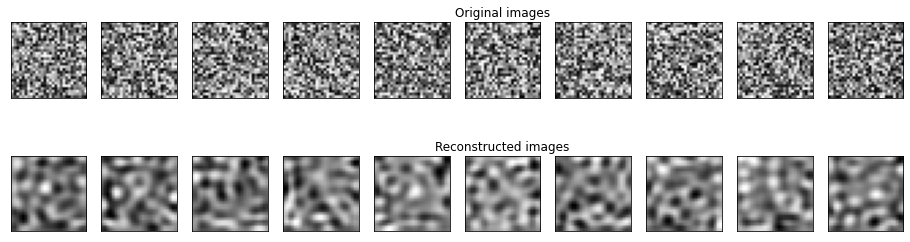

EPOCH 51/200 	 train loss 0.0730038434267044 	 val loss 0.07309547811746597
EPOCH 52/200 	 train loss 0.07298197597265244 	 val loss 0.07313356548547745
EPOCH 53/200 	 train loss 0.07299017906188965 	 val loss 0.07305821031332016
EPOCH 54/200 	 train loss 0.0730070248246193 	 val loss 0.07306762784719467
EPOCH 55/200 	 train loss 0.07299397885799408 	 val loss 0.07316688448190689
EPOCH 56/200 	 train loss 0.07303014397621155 	 val loss 0.07316509634256363
EPOCH 57/200 	 train loss 0.07298878580331802 	 val loss 0.07297465205192566
EPOCH 58/200 	 train loss 0.07301745563745499 	 val loss 0.07300972938537598
EPOCH 59/200 	 train loss 0.07300273329019547 	 val loss 0.07310514897108078
EPOCH 60/200 	 train loss 0.0729788988828659 	 val loss 0.07322018593549728


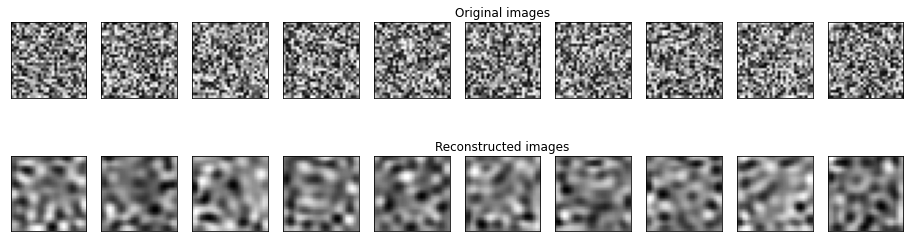

EPOCH 61/200 	 train loss 0.0730062872171402 	 val loss 0.0730930045247078
EPOCH 62/200 	 train loss 0.07300371676683426 	 val loss 0.07317980378866196
EPOCH 63/200 	 train loss 0.07299322634935379 	 val loss 0.07315147668123245
EPOCH 64/200 	 train loss 0.07298161089420319 	 val loss 0.07302606105804443
EPOCH 65/200 	 train loss 0.07299420982599258 	 val loss 0.07321783155202866
EPOCH 66/200 	 train loss 0.07300234586000443 	 val loss 0.07292879372835159
EPOCH 67/200 	 train loss 0.07298225909471512 	 val loss 0.07325037568807602
EPOCH 68/200 	 train loss 0.0729871392250061 	 val loss 0.07304099202156067
EPOCH 69/200 	 train loss 0.07299169152975082 	 val loss 0.07326996326446533
EPOCH 70/200 	 train loss 0.0729912668466568 	 val loss 0.07307091355323792


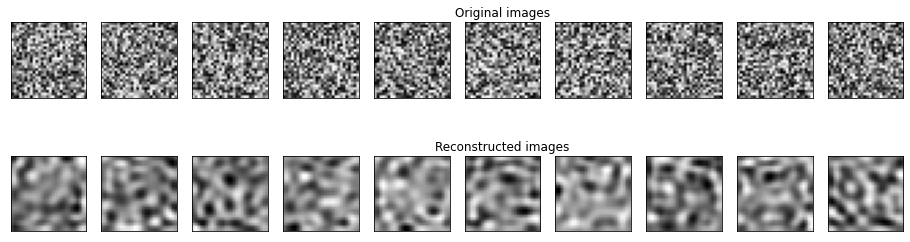

EPOCH 71/200 	 train loss 0.0729682669043541 	 val loss 0.07302222400903702
EPOCH 72/200 	 train loss 0.07297857105731964 	 val loss 0.07319937646389008
EPOCH 73/200 	 train loss 0.07298815250396729 	 val loss 0.07317309081554413
EPOCH 74/200 	 train loss 0.07299038767814636 	 val loss 0.07305827736854553
EPOCH 75/200 	 train loss 0.07298800349235535 	 val loss 0.07321920990943909
EPOCH 76/200 	 train loss 0.07299835234880447 	 val loss 0.07304248213768005
EPOCH 77/200 	 train loss 0.07298450917005539 	 val loss 0.07345037907361984
EPOCH 78/200 	 train loss 0.07297510653734207 	 val loss 0.07313994318246841
EPOCH 79/200 	 train loss 0.07299081981182098 	 val loss 0.07299019396305084
EPOCH 80/200 	 train loss 0.0729820653796196 	 val loss 0.07318313419818878


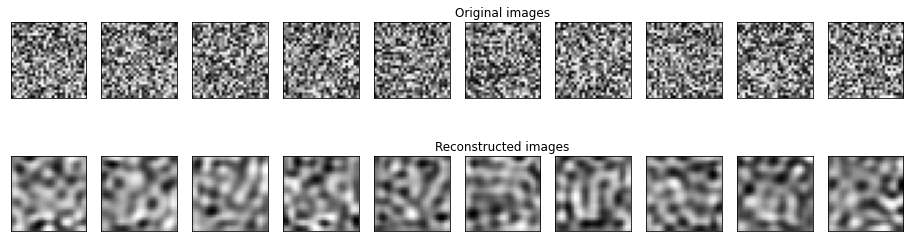

EPOCH 81/200 	 train loss 0.07300621271133423 	 val loss 0.07316949963569641
EPOCH 82/200 	 train loss 0.07298894971609116 	 val loss 0.0730830579996109
EPOCH 83/200 	 train loss 0.07297597080469131 	 val loss 0.07304838299751282
EPOCH 84/200 	 train loss 0.07299557328224182 	 val loss 0.07302740216255188
EPOCH 85/200 	 train loss 0.07299735397100449 	 val loss 0.07312512397766113
EPOCH 86/200 	 train loss 0.0729726254940033 	 val loss 0.07375548034906387
EPOCH 87/200 	 train loss 0.0729791596531868 	 val loss 0.07304544746875763
EPOCH 88/200 	 train loss 0.07298789918422699 	 val loss 0.07327570021152496
EPOCH 89/200 	 train loss 0.07297780364751816 	 val loss 0.07299952954053879
EPOCH 90/200 	 train loss 0.07296987622976303 	 val loss 0.07309753447771072


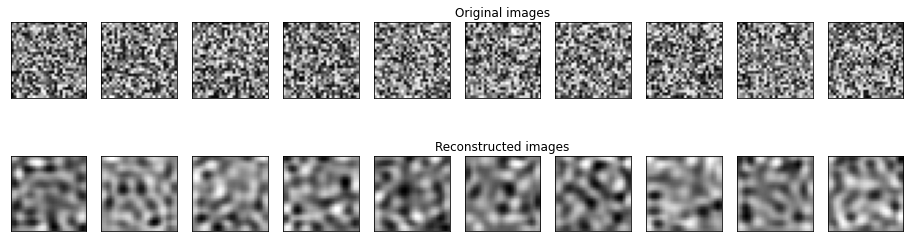

EPOCH 91/200 	 train loss 0.0729924663901329 	 val loss 0.07322880625724792
EPOCH 92/200 	 train loss 0.07295429706573486 	 val loss 0.07309616357088089
EPOCH 93/200 	 train loss 0.07296914607286453 	 val loss 0.07312282174825668
EPOCH 94/200 	 train loss 0.07299531996250153 	 val loss 0.0730101466178894
EPOCH 95/200 	 train loss 0.07301706075668335 	 val loss 0.07306504994630814
EPOCH 96/200 	 train loss 0.07300116866827011 	 val loss 0.07297877967357635
EPOCH 97/200 	 train loss 0.07297979295253754 	 val loss 0.07301925122737885
EPOCH 98/200 	 train loss 0.0729830339550972 	 val loss 0.07325845956802368
EPOCH 99/200 	 train loss 0.07299438118934631 	 val loss 0.07320581376552582
EPOCH 100/200 	 train loss 0.07297991216182709 	 val loss 0.07306119054555893


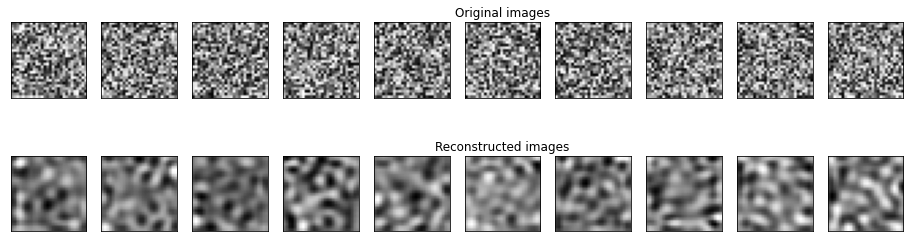

EPOCH 101/200 	 train loss 0.07297666370868683 	 val loss 0.07331390678882599
EPOCH 102/200 	 train loss 0.07300026714801788 	 val loss 0.07301877439022064
EPOCH 103/200 	 train loss 0.07297451794147491 	 val loss 0.07308829575777054
EPOCH 104/200 	 train loss 0.07297821342945099 	 val loss 0.07319395989179611
EPOCH 105/200 	 train loss 0.07298274338245392 	 val loss 0.07309944182634354
EPOCH 106/200 	 train loss 0.07298742234706879 	 val loss 0.07311931997537613
EPOCH 107/200 	 train loss 0.07297488301992416 	 val loss 0.07315311580896378
EPOCH 108/200 	 train loss 0.07297568768262863 	 val loss 0.07302875816822052
EPOCH 109/200 	 train loss 0.07297296077013016 	 val loss 0.07319916784763336
EPOCH 110/200 	 train loss 0.07298123836517334 	 val loss 0.0733303502202034


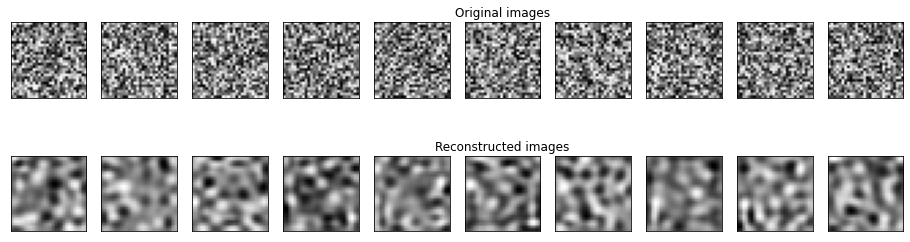

EPOCH 111/200 	 train loss 0.07297436147928238 	 val loss 0.07396897673606873
EPOCH 112/200 	 train loss 0.0729638859629631 	 val loss 0.0734545961022377
EPOCH 113/200 	 train loss 0.07297816872596741 	 val loss 0.07311349362134933
EPOCH 114/200 	 train loss 0.07297956943511963 	 val loss 0.07329893112182617
EPOCH 115/200 	 train loss 0.07298573851585388 	 val loss 0.0730128139257431
EPOCH 116/200 	 train loss 0.07296691089868546 	 val loss 0.07303958386182785
EPOCH 117/200 	 train loss 0.07297159731388092 	 val loss 0.07326905429363251
EPOCH 118/200 	 train loss 0.07298652082681656 	 val loss 0.07314957678318024
EPOCH 119/200 	 train loss 0.07298651337623596 	 val loss 0.07310311496257782
EPOCH 120/200 	 train loss 0.07296547293663025 	 val loss 0.07300470024347305


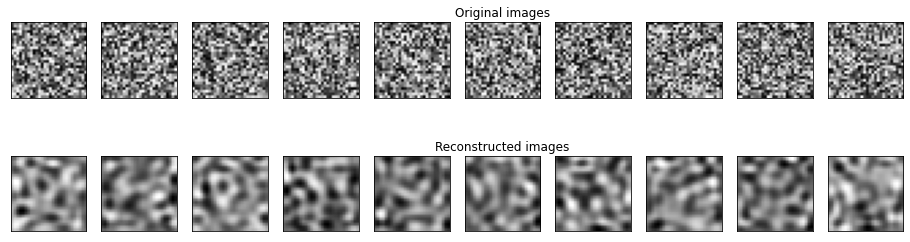

EPOCH 121/200 	 train loss 0.0729527398943901 	 val loss 0.07301388680934906
EPOCH 122/200 	 train loss 0.07298419624567032 	 val loss 0.07302968949079514
EPOCH 123/200 	 train loss 0.07297705858945847 	 val loss 0.07297729700803757
EPOCH 124/200 	 train loss 0.07297954708337784 	 val loss 0.07311727851629257
EPOCH 125/200 	 train loss 0.0729781910777092 	 val loss 0.07334981858730316
EPOCH 126/200 	 train loss 0.0729680135846138 	 val loss 0.0735538899898529
EPOCH 127/200 	 train loss 0.07296596467494965 	 val loss 0.07295317202806473
EPOCH 128/200 	 train loss 0.07295390218496323 	 val loss 0.07316377758979797
EPOCH 129/200 	 train loss 0.07296989858150482 	 val loss 0.07338163256645203
EPOCH 130/200 	 train loss 0.07297049462795258 	 val loss 0.07368211448192596


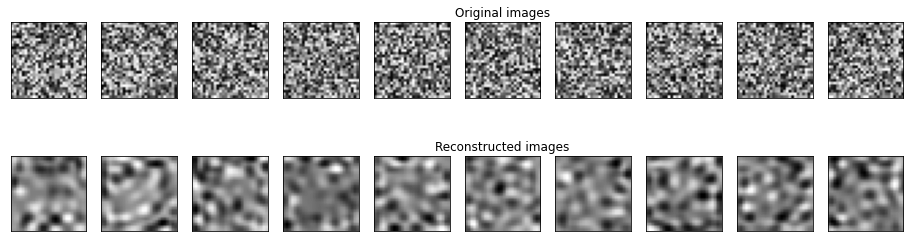

EPOCH 131/200 	 train loss 0.0729537382721901 	 val loss 0.07323455810546875
EPOCH 132/200 	 train loss 0.07296418398618698 	 val loss 0.07302270829677582
EPOCH 133/200 	 train loss 0.07298585027456284 	 val loss 0.07310179620981216
EPOCH 134/200 	 train loss 0.0729702040553093 	 val loss 0.07332848757505417
EPOCH 135/200 	 train loss 0.07298059016466141 	 val loss 0.07313156872987747
EPOCH 136/200 	 train loss 0.07298219949007034 	 val loss 0.073176309466362
EPOCH 137/200 	 train loss 0.07297766208648682 	 val loss 0.07299144566059113
EPOCH 138/200 	 train loss 0.07296529412269592 	 val loss 0.07333505153656006
EPOCH 139/200 	 train loss 0.07297874987125397 	 val loss 0.07325776666402817
EPOCH 140/200 	 train loss 0.07297997921705246 	 val loss 0.07313145697116852


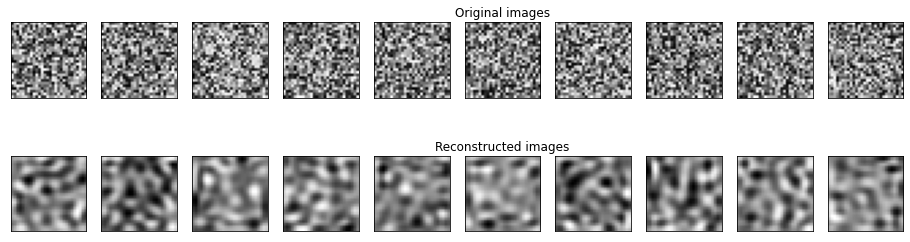

EPOCH 141/200 	 train loss 0.07297442853450775 	 val loss 0.07338376343250275
EPOCH 142/200 	 train loss 0.07299023121595383 	 val loss 0.07304534316062927
EPOCH 143/200 	 train loss 0.0729735866189003 	 val loss 0.07309127599000931
EPOCH 144/200 	 train loss 0.072957344353199 	 val loss 0.07315381616353989
EPOCH 145/200 	 train loss 0.072977714240551 	 val loss 0.07392464578151703
EPOCH 146/200 	 train loss 0.07296562194824219 	 val loss 0.07319241762161255
EPOCH 147/200 	 train loss 0.07296589761972427 	 val loss 0.07305806130170822
EPOCH 148/200 	 train loss 0.07296904176473618 	 val loss 0.0730336606502533
EPOCH 149/200 	 train loss 0.07297394424676895 	 val loss 0.07305344194173813
EPOCH 150/200 	 train loss 0.07296103984117508 	 val loss 0.07312079519033432


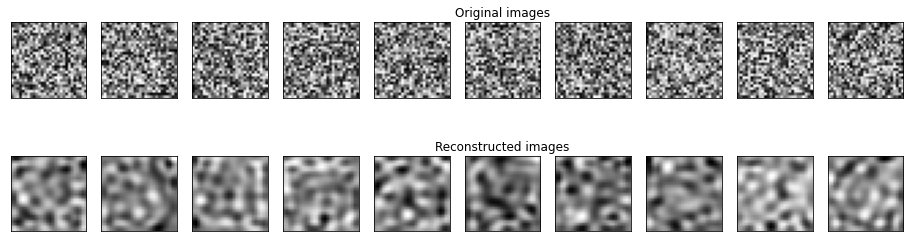

EPOCH 151/200 	 train loss 0.07295630127191544 	 val loss 0.07303659617900848
EPOCH 152/200 	 train loss 0.07296714186668396 	 val loss 0.07315582782030106
EPOCH 153/200 	 train loss 0.07299397140741348 	 val loss 0.07312356680631638
EPOCH 154/200 	 train loss 0.07297659665346146 	 val loss 0.07306413352489471
EPOCH 155/200 	 train loss 0.07296596467494965 	 val loss 0.07323689758777618
EPOCH 156/200 	 train loss 0.07295946031808853 	 val loss 0.07300547510385513
EPOCH 157/200 	 train loss 0.07297070324420929 	 val loss 0.0733524039387703
EPOCH 158/200 	 train loss 0.07295665144920349 	 val loss 0.07319554686546326
EPOCH 159/200 	 train loss 0.07294221967458725 	 val loss 0.07329665869474411
EPOCH 160/200 	 train loss 0.07296906411647797 	 val loss 0.0731387734413147


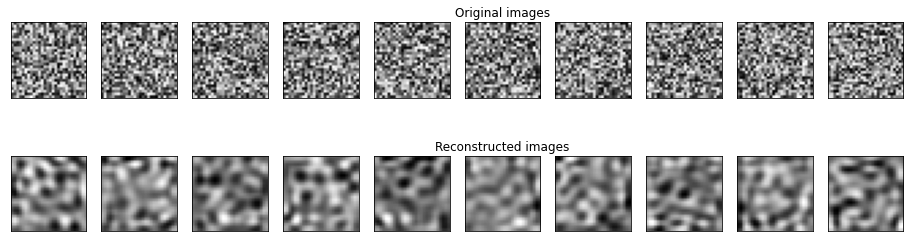

EPOCH 161/200 	 train loss 0.0729832649230957 	 val loss 0.07299759238958359
EPOCH 162/200 	 train loss 0.07294421643018723 	 val loss 0.07309157401323318
EPOCH 163/200 	 train loss 0.07296092808246613 	 val loss 0.07331833988428116
EPOCH 164/200 	 train loss 0.07296302169561386 	 val loss 0.07306715101003647
EPOCH 165/200 	 train loss 0.0729643777012825 	 val loss 0.07363655418157578
EPOCH 166/200 	 train loss 0.07297937572002411 	 val loss 0.07386798411607742
EPOCH 167/200 	 train loss 0.07296471297740936 	 val loss 0.07313122600317001
EPOCH 168/200 	 train loss 0.07296773046255112 	 val loss 0.07381034642457962
EPOCH 169/200 	 train loss 0.0729856863617897 	 val loss 0.07302127033472061
EPOCH 170/200 	 train loss 0.07293705642223358 	 val loss 0.07298526912927628


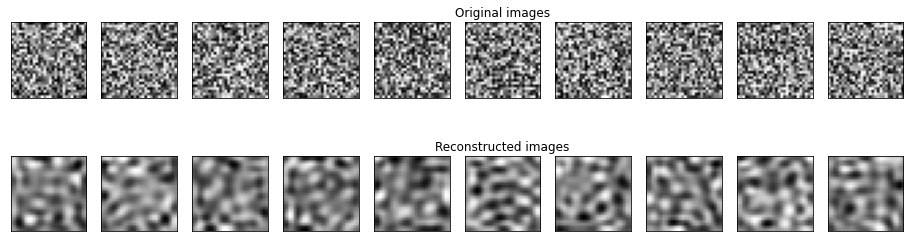

EPOCH 171/200 	 train loss 0.07296569645404816 	 val loss 0.07310856878757477
EPOCH 172/200 	 train loss 0.07294654846191406 	 val loss 0.07304931432008743
EPOCH 173/200 	 train loss 0.07295956462621689 	 val loss 0.07353305071592331
EPOCH 174/200 	 train loss 0.07296650111675262 	 val loss 0.07313712686300278
EPOCH 175/200 	 train loss 0.07295159250497818 	 val loss 0.07323677837848663
EPOCH 176/200 	 train loss 0.07297347486019135 	 val loss 0.07305173575878143
EPOCH 177/200 	 train loss 0.07296536862850189 	 val loss 0.07309512794017792
EPOCH 178/200 	 train loss 0.07293689996004105 	 val loss 0.07329585403203964
EPOCH 179/200 	 train loss 0.07295875251293182 	 val loss 0.0729818046092987
EPOCH 180/200 	 train loss 0.0729670599102974 	 val loss 0.07304489612579346


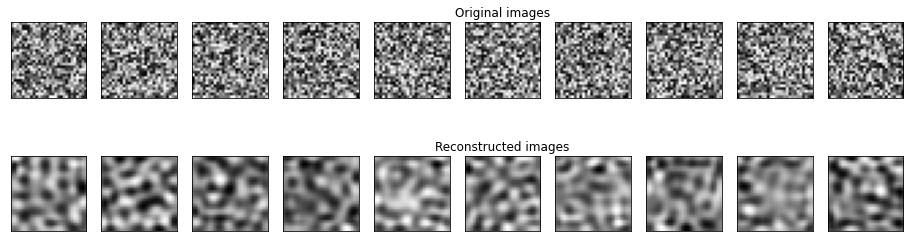

EPOCH 181/200 	 train loss 0.0729731023311615 	 val loss 0.07332836091518402
EPOCH 182/200 	 train loss 0.07296016067266464 	 val loss 0.0729808658361435
EPOCH 183/200 	 train loss 0.07295367121696472 	 val loss 0.07307936996221542
EPOCH 184/200 	 train loss 0.07296127080917358 	 val loss 0.07312193512916565
EPOCH 185/200 	 train loss 0.0729525163769722 	 val loss 0.07300985604524612
EPOCH 186/200 	 train loss 0.07294205576181412 	 val loss 0.0731109082698822
EPOCH 187/200 	 train loss 0.07297030836343765 	 val loss 0.0731145441532135
EPOCH 188/200 	 train loss 0.0729733556509018 	 val loss 0.0732782855629921
EPOCH 189/200 	 train loss 0.0729731097817421 	 val loss 0.07304808497428894
EPOCH 190/200 	 train loss 0.07294057309627533 	 val loss 0.07324882596731186


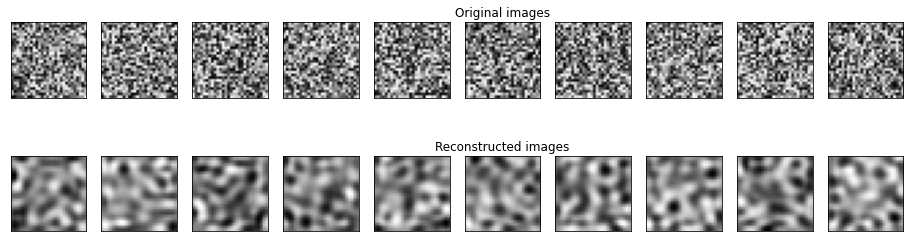

EPOCH 191/200 	 train loss 0.0729539543390274 	 val loss 0.07320229709148407
EPOCH 192/200 	 train loss 0.07297950237989426 	 val loss 0.0730382651090622
EPOCH 193/200 	 train loss 0.07295393943786621 	 val loss 0.07326509803533554
EPOCH 194/200 	 train loss 0.07295947521924973 	 val loss 0.07315406948328018
EPOCH 195/200 	 train loss 0.07297025620937347 	 val loss 0.07344072312116623
EPOCH 196/200 	 train loss 0.07297810167074203 	 val loss 0.07303838431835175
EPOCH 197/200 	 train loss 0.07295065373182297 	 val loss 0.07335862517356873
EPOCH 198/200 	 train loss 0.07296192646026611 	 val loss 0.07348769903182983
EPOCH 199/200 	 train loss 0.07298620790243149 	 val loss 0.0730244517326355
EPOCH 200/200 	 train loss 0.0729515478014946 	 val loss 0.07372584939002991


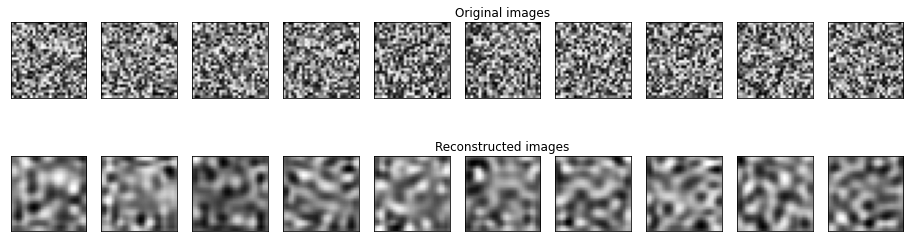

In [16]:
num_epochs = 200
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   if (((epoch+1) % 10) == 0):
      plot_ae_outputs(encoder,decoder,n=10)

In [17]:
def plot_ae_outputs_mnist(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

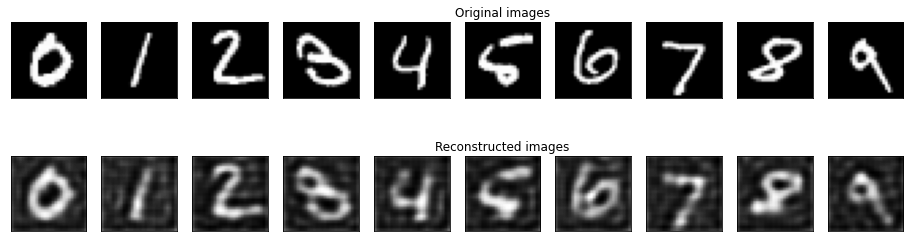

In [18]:
plot_ae_outputs_mnist(encoder, decoder, 10)